# Interatomic force field (IFF) optimization for W-based metal alloys

Author: Lukas Vlcek

Start Date: 2018-04-22

In [1]:
from datetime import datetime ; print('Last update:', datetime.now())

Last update: 2018-04-23 13:05:51.717644


## 1. Target data overview

### Bulk properties of tungsten
from _Marinica et.al_ except for B (bulk modulus) and Pc (Cauchy pressure)

T=0K?

| Property | BCC | FCC |
| :---     | :---: | :---: |
| a_0 (A) | 3.1648 | 4.054 |
| E_coh (eV/atom) | -8.9 | -8.43 |
| C11 (GPa) | 523 | - |
| C12 (GPa) | 203 | - |
| C44 (GPa) | 160 | - |
| B (GPa) | 310.4 | - |
| Pc (GPa) | 21.9 | - |

### Defect properties
(from _Marinica et.al_)

Based on 128+-1 atoms

Defect | Energy (eV)
:--- | :---:
(111) | 10.53
(110) | 10.82
(100) | 12.87
OCT | 13.11
TET | 12.27
Vacancy | 3.49

### Atomic configurations and DFT data

1. Data from Marinica
  * 20 configurations generated from liquid Fe trajectory, N=113
  * DFT Forces
  * DFT Energy
2. Data from German (local minimum energy configs.)
  * Energy, Hessians?
  * Pure phases
    * BCC (54 atoms)
    * FCC (32 atoms)
  * Vacancy (53 atoms)
  * Interstitial defects 
    * 110, 111 (55 atoms)
    * 111_easy_core (135 atoms)?

## 2. Processing of raw data into HDF5 storage

In [2]:
%matplotlib inline
import os
import glob
import re
import numpy as np
import h5py
import matplotlib.pyplot as plt

# source of raw data and destination for processed data
target_raw = '../data/target_raw'
target_proc = '../data/target_processed'

### Data from Marinica

coordinates
energies
forces
4000.0
coordinates (17, 113, 3) 1.70206
forces (17, 113, 3) -8.55918


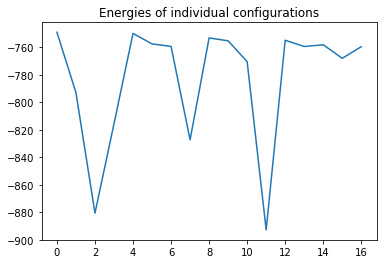

In [3]:
# source and destination directories
marini_raw = os.path.join(target_raw, 'marinica_cfg')
marini_proc = os.path.join(target_proc, 'marini')

# columns in a fixed format file
rcols = ( (4,14), (14,24), (24,34))  # atomic coordinates
fcols = ((34,44), (44,54), (54,64))  # atomic forces

# read target data from Marinica, extract energies, xyz, forces
enes, xyzs, frcs = [],[],[] # list of coordinates, energies, forces
for file in glob.glob(os.path.join(marini_raw, '*.ref')):
    #print(file)
    with open(file, 'r') as fi:
        ene = float(re.findall('\S+', fi.readline())[1])
        nat = int(re.findall('\S+', fi.readline())[1])
        xyz = np.zeros((nat, 3), dtype=float)
        frc = np.zeros((nat, 3), dtype=float)
        #print('number of atoms:', nat, '\nenergy:', ene)
        for i in range(nat):
            line = fi.readline()
            xyz[i] = [float(line[c[0]:c[1]]) for c in rcols]
            frc[i] = [float(line[c[0]:c[1]]) for c in fcols]
        enes.append(ene)
        xyzs.append(xyz)
        frcs.append(frc)

enes = np.array(enes)
xyzs = np.array(xyzs)
frcs = np.array(frcs)

# save all trajectory data in an hdf5 file
with h5py.File(os.path.join(target_proc, "marini_dft.hdf5"), "w") as fo:
    fo.attrs['temperature (K)'] = 4000.0
    dset_e = fo.create_dataset("energies", enes.shape, dtype='f')
    dset_e[...] = enes
    dset_r = fo.create_dataset("coordinates", xyzs.shape, dtype='f')
    dset_r[...] = xyzs
    dset_f = fo.create_dataset("forces", frcs.shape, dtype='f')
    dset_f[...] = frcs

# Check if the new file is OK
with h5py.File(os.path.join(target_proc, "marini_dft.hdf5"), "r") as fi:
    fi.visit(lambda x: print(x))
    print(fi.attrs['temperature (K)'])
    for name in fi:
        if name != 'energies':
            print(name, fi[name].shape, fi[name][0,0,0])
    plt.plot(fi['energies'])
    plt.title('Energies of individual configurations')

### Data from German

In [4]:
# source and destination directories
german_raw = os.path.join(target_raw, 'dft_w')
german_proc = os.path.join(target_proc, 'german')

# directories with specific 0K data
dirlist = ['bcc', 'fcc', 'vacancy', '110', '111']
dirlist = [os.path.join(german_raw, cdir) for cdir in dirlist]
print(dirlist)

# read appropriate contents - coordinates, energies, Hessians?
for cdir in dirlist:
    with open(os.path.join(cdir, 'rlx.out')) as fi:
        pass
                          
#with h5py.File("german_dft.hdf5", "w") as fo:
#    dset = fo.create_dataset("mydataset", (100,), dtype='i')

['../data/target_raw/dft_w/bcc', '../data/target_raw/dft_w/fcc', '../data/target_raw/dft_w/vacancy', '../data/target_raw/dft_w/110', '../data/target_raw/dft_w/111']


## 3. IFF functional form

### 3.1 Finnis-Sinclair potential

Energy of an N-particle configuration

$$ E = \sum_{i=1}^N \left[ \sum_{j>i}^N V\left(r_{ij}\right) + F\left(\rho_i\right) \right] $$

Pair interaction

$$ V\left(r_{ij}\right) = \left(r_{ij}-c\right)^2\left(c_0 + c_1r_{ij} + c_2r_{ij}^2\right),\,\, r_{ij}\le c $$


Embedded function

$$ F = -A\sqrt{\rho_i} $$

Effective electron density

$$ \rho_i = \sum_{j\ne i}^N \phi\left(r_{ij}\right) $$

Cohesive potential

$$ \phi\left(r_{ij}\right) = \left(r_{ij}-d\right)^2,\,\, r_{ij}\le d $$

** Starting W parameters: ** (Finnis and Sinclair, _Phil. Mag. A_, **50(1)**, 45-66, 1984)
* Fixed
  * d = 4.400224
  * c = 3.25
* To be optimized
  * A = 1.896373
  * c0 = 47.1346499
  * c1 = -33.7665655
  * c2 = 6.2541999

## 4. Loss function

**Squared statistical distance**

  $$ s^2 = \arccos^2\left(C_B\right) $$


1. Ab initio data
  * Energies
    $$ C_B = \sum_{k=1}^{kmax} \exp\left[ -\beta\left(\Delta u_k - \Delta F\right)/2\right] $$
  * Forces
  * Hessians

2. Structural fluctuations
  * Fit Gaussian distributions described by bulk parameters
    * Mean values (A): lattice parameters (at a particular T
    * Variance (V): depends on elastic constants
    
  $$ \ln\left(C_B\right) = \frac{1}{4k_BT^2}\frac{\left(A_M - A_T\right)^2}{4\left(V_M - V_T\right)} - \frac{1}{4}\ln\frac{4 V_MV_T}{\left(V_M+V_T\right)^2} $$ 
  
  * How exactly are the different elastic constants defined?
  * Translate C11, C12, C44 to variances

## 5. Optimization

* A set of Fortran codes for parameter search on grid at:'https://github.com/vlcekl/sopt/tree/master/src/optimize/search_grid'
* A Python script for simplex search at https://github.com/vlcekl/sopt/tree/master/src/optimize/search_simplex

** Currently performing parameter grid search for FS potential ** 